In [1]:

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline


In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df


,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:

norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


In [6]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [7]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [8]:

i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


In [9]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


In [13]:

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
#                 rankdir='TB').create(prog='dot', format='svg'))


In [14]:

for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Instructions for updating:
Use tf.cast instead.
Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 3970557.1022222214

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 4235678.190664927

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 4219945.078430535

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 4 	Loss: 4244319.583073954

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 5 	Loss: 4295968.488685335



In [15]:
import dill
dill.dump_session('notebook_env.db')


In [18]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,0.461231,1.244663,-0.967635,-0.573551,0.303226,0.459785,-1.049965,2.108813,1.849385,0.530530,...,0.585170,-0.338756,-0.817164,-0.886092,0.286433,-0.503845,0.523289,0.371361,2.669681,1.370127
lord,1.528878,2.468793,-0.365063,0.331183,1.110088,0.895110,1.076699,1.953056,0.694757,2.358592,...,0.421022,-0.071273,-0.367895,0.522257,-0.760728,1.462651,1.574251,0.123071,0.923479,2.245579
thou,0.410491,0.697635,-0.448407,1.726354,-0.323329,0.360345,-0.134890,1.505585,-0.068806,-1.128600,...,0.048148,-0.740259,-0.243897,0.567982,-0.414588,0.712533,-0.226220,0.444339,1.405796,0.148675
thy,0.949307,1.764417,-0.403812,0.560838,0.466351,0.671925,0.112732,1.372453,1.011372,0.786794,...,-0.661982,0.226071,-1.208231,0.551014,-0.054960,0.739063,1.104755,1.600116,0.387501,0.425430
god,0.884563,0.841295,-0.869834,0.055219,0.129518,0.275884,0.233068,1.129054,0.196256,-0.445979,...,0.793787,-0.274763,-0.926835,-0.280457,-0.335312,0.952852,0.489901,0.769145,2.053357,0.571499


In [20]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['things', 'also', 'behold', 'give', 'might'],
 'jesus': ['world', 'spirit', 'faith', 'glory', 'paul'],
 'noah': ['shem', 'adam', 'lamech', 'eber', 'enoch'],
 'egypt': ['field', 'became', 'fruit', 'money', 'army'],
 'john': ['vision', 'galilee', 'peter', 'journey', 'seeth'],
 'gospel': ['preached', 'church', 'scripture', 'tongues', 'abundantly'],
 'moses': ['pharaoh', 'number', 'aaron', 'woman', 'priest'],
 'famine': ['countries', 'branches', 'wickedness', 'wonders', 'violence']}

In [21]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [22]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(king (13), slips (10784)) -> 0
(bible (5766), james (1154)) -> 1
(bible (5766), evi (7041)) -> 0
(bible (5766), christian (8312)) -> 0
(bible (5766), king (13)) -> 1
(james (1154), kindred (1714)) -> 0
(king (13), james (1154)) -> 1
(king (13), bible (5766)) -> 1
(king (13), bilgah (6254)) -> 0
(james (1154), kirjathjearim (2325)) -> 0


In [40]:
from keras import models
from keras import layers
from keras import Input, Model

word_input = Input(shape=(1,))
word_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(word_input)
word_reshape = layers.Reshape((embed_size,))(word_x)

word_model = Model(word_input, word_reshape)    

context_input = Input(shape=(1,))
context_x = layers.Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform')(context_input)
context_reshape = layers.Reshape((embed_size,))(context_x)

context_model = Model(context_input, context_reshape)

#model_input = layers.dot([word_model, context_model], axes=1, normalize=False)
dot_output = layers.dot([word_reshape, context_reshape], axes=1, normalize=False)
model_output = layers.Dense(1, kernel_initializer='glorot_uniform',activation='sigmoid')(dot_output)
#

In [42]:
model = Model([word_input, context_input], model_output)

In [43]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 100)       1242500     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 100)       1242500     input_6[0][0]                    
__________________________________________________________________________________________________
reshape_19

In [46]:
model.compile(loss="mean_squared_error", optimizer="rmsprop")
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 4456.992513405625
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3739.331936176284
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3743.956065599894
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3761.9311267106823
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Ep

In [51]:
#merge_layer = model.layers[0]
#word_model = merge_layer.layers[0]
#word_embed_layer = word_model.layers[0]
#weights = word_embed_layer.get_weights()[0][1:]

#print(weights.shape)
#pd.DataFrame(weights, index=id2word.values()).head()

AttributeError: 'InputLayer' object has no attribute 'layers'

In [52]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['things', 'also', 'behold', 'give', 'might'],
 'jesus': ['world', 'spirit', 'faith', 'glory', 'paul'],
 'noah': ['shem', 'adam', 'lamech', 'eber', 'enoch'],
 'egypt': ['field', 'became', 'fruit', 'money', 'army'],
 'john': ['vision', 'galilee', 'peter', 'journey', 'seeth'],
 'gospel': ['preached', 'church', 'scripture', 'tongues', 'abundantly'],
 'moses': ['pharaoh', 'number', 'aaron', 'woman', 'priest'],
 'famine': ['countries', 'branches', 'wickedness', 'wonders', 'violence']}

Total words: 48 	Word Embedding shapes: (48, 100)


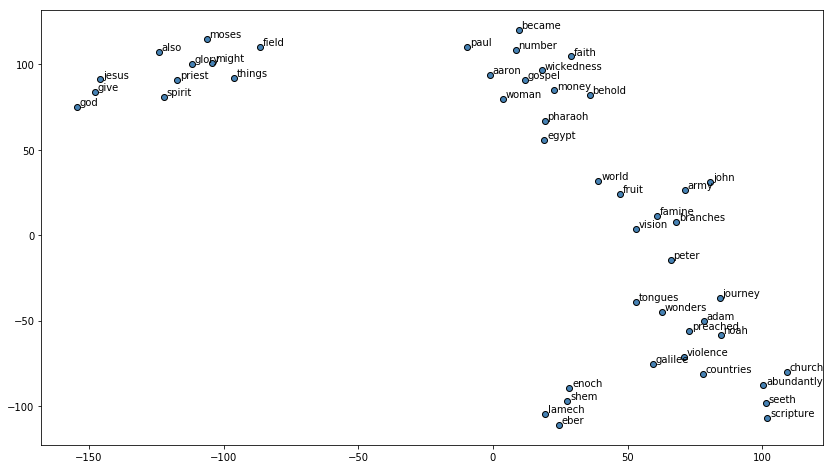

In [53]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [56]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['promised', 'lord', 'glory', 'us', 'lovingkindness'],
 'jesus': ['messias', 'peter', 'immediately', 'james', 'john'],
 'noah': ['shem', 'ham', 'japheth', 'enosh', 'kenan'],
 'egypt': ['egyptians', 'pharaoh', 'bondage', 'flowing', 'rid'],
 'john': ['james', 'baptist', 'peter', 'tetrarch', 'galilee'],
 'gospel': ['christ', 'faith', 'afflictions', 'godly', 'preach'],
 'moses': ['congregation', 'children', 'aaron', 'ordinance', 'elisheba'],
 'famine': ['pestilence', 'peril', 'overtaketh', 'sword', 'deaths']}

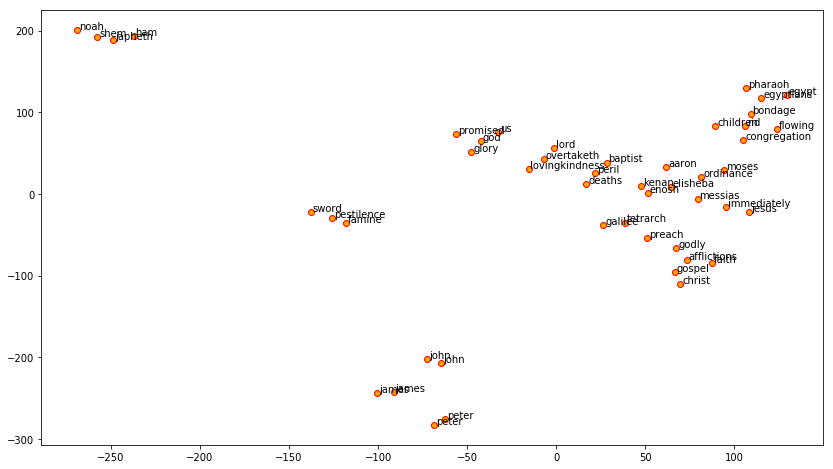

In [57]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [58]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

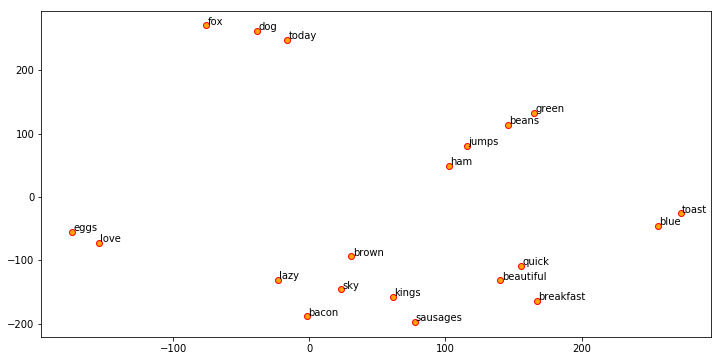

In [59]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [60]:
w2v_model.wv['sky']

array([-0.05067615,  0.02551475,  0.00704014,  0.00016917,  0.00449414,
       -0.01274991, -0.00915528, -0.01247271, -0.05056653,  0.03158471],
      dtype=float32)

In [61]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [62]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

c:\users\mglewis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,-0.048057,0.032209,0.016816,-0.015661,0.004190,0.000155,0.006240,0.000950,-0.007915,0.008677
1,-0.026688,0.027502,0.024985,-0.019130,-0.007831,-0.011287,-0.006674,-0.008307,-0.004762,0.006803
2,-0.005713,0.026145,0.011739,-0.015723,0.023463,0.012229,0.007393,0.002117,-0.027571,-0.004873
3,-0.022122,-0.000913,0.015565,0.008562,0.004473,0.007852,-0.008008,-0.000869,-0.009172,-0.001761
4,-0.002389,-0.005321,0.023379,0.012066,-0.000460,-0.006057,-0.025641,-0.012065,-0.011718,0.000533
5,-0.014994,0.030462,0.005787,-0.024791,0.017275,0.007817,0.005634,0.001690,-0.022330,-0.006526
6,-0.029964,0.024481,0.015658,-0.002272,0.004616,0.003584,0.006467,0.007601,-0.024388,0.007563
7,-0.007640,0.028720,0.004050,-0.023788,0.020516,0.015239,0.003661,-0.000451,-0.031064,-0.012107


In [63]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


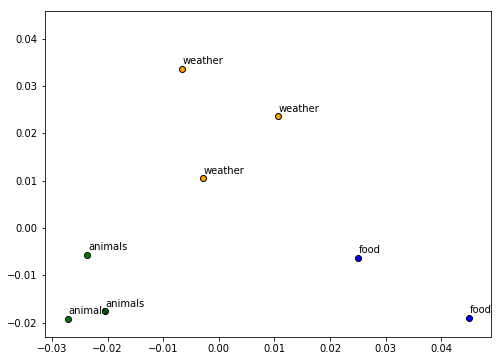

In [64]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

In [70]:
import spacy

nlp = spacy.load('en')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 0


In [71]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
love,5.752973,-1.369995,2.740354,-2.547042,-2.789080,-0.963038,0.565061,-1.000550,-2.761724,-0.424854,...,0.456829,-2.432288,5.886449,-1.462700,1.469907,-0.907472,-1.432700,-1.795017,-2.538611,3.624874
fox,1.951795,-0.997128,-0.433151,-2.571720,-1.737313,-0.472976,0.304336,-1.050771,-0.790423,0.539000,...,0.135222,-0.015412,5.036503,-2.552611,1.525144,3.253964,0.314472,-2.270474,-1.755432,2.271015
jumps,4.982572,2.689378,1.083144,-3.210576,1.034403,-0.194685,0.956864,2.572975,1.367885,0.291178,...,-1.141734,1.183726,2.951894,-2.994605,-0.880542,3.039500,-0.512581,0.372516,-1.360234,-1.183976
quick,-0.598666,-1.158306,-3.909991,-0.372394,1.947248,-0.062386,2.115515,-0.791646,-0.281300,-0.309056,...,3.075489,0.889506,3.620712,-1.092860,3.872990,2.059921,-1.751325,-1.977855,-0.352193,-0.584711
breakfast,6.556321,-1.651478,1.498230,-4.397271,-0.939667,-1.912575,-0.321350,-1.432454,-3.410478,3.026453,...,2.162867,-1.168921,5.796451,-2.759970,1.715275,0.597053,1.415332,-1.861534,-1.444214,7.522689
beautiful,-1.597225,-0.764705,-1.936277,-3.709085,0.872238,-0.122071,3.515678,0.086001,-1.459588,-3.823340,...,4.499368,1.891069,2.969625,0.074327,8.217148,2.430661,-0.801117,-0.229828,1.598215,-1.499999
lazy,-1.096740,0.809550,-0.847943,-2.706778,1.270975,-0.360892,3.787191,0.205429,-0.771523,-1.649070,...,3.817393,-0.548147,5.858270,-2.256131,3.164148,2.249343,-4.017901,-3.003520,1.266805,1.364671
bacon,4.888225,-1.579860,2.250743,-3.445149,-1.313023,-2.745319,0.422232,0.065402,-2.258757,3.166237,...,0.451559,0.572528,6.394579,0.679203,3.810830,1.650660,-1.656797,-0.078714,-2.438452,3.246970
brown,0.773028,-2.011893,-3.083411,-3.498830,2.212976,0.228652,3.557878,0.743633,-0.642961,-0.272392,...,3.673551,0.466298,4.076053,-0.731111,3.312191,2.540089,-1.560781,-1.713369,-0.120708,3.500929
green,-0.465192,-1.094277,-3.627850,-0.217454,-0.146710,2.360640,0.994361,2.341765,-0.175684,0.600770,...,0.432555,1.125682,3.314737,-3.134842,5.482526,3.531374,1.676527,-0.800146,1.396110,1.461131


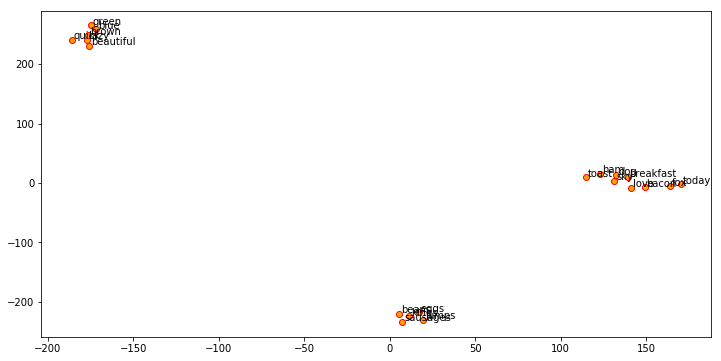

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [74]:
from sklearn.cluster import KMeans
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


In [75]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [76]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'unto', 'therefore', 'jesus', 'things'],
 'jesus': ['christ', 'god', 'disciples', 'faith', 'grace'],
 'noah': ['methuselah', 'milcah', 'shem', 'mahalaleel', 'flood'],
 'egypt': ['land', 'pharaoh', 'egyptians', 'pathros', 'shur'],
 'john': ['baptist', 'baptize', 'peter', 'baptized', 'galilee'],
 'gospel': ['preached', 'christ', 'preach', 'preaching', 'faith'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'eleazar'],
 'famine': ['pestilence', 'sword', 'dearth', 'die', 'sojourn']}

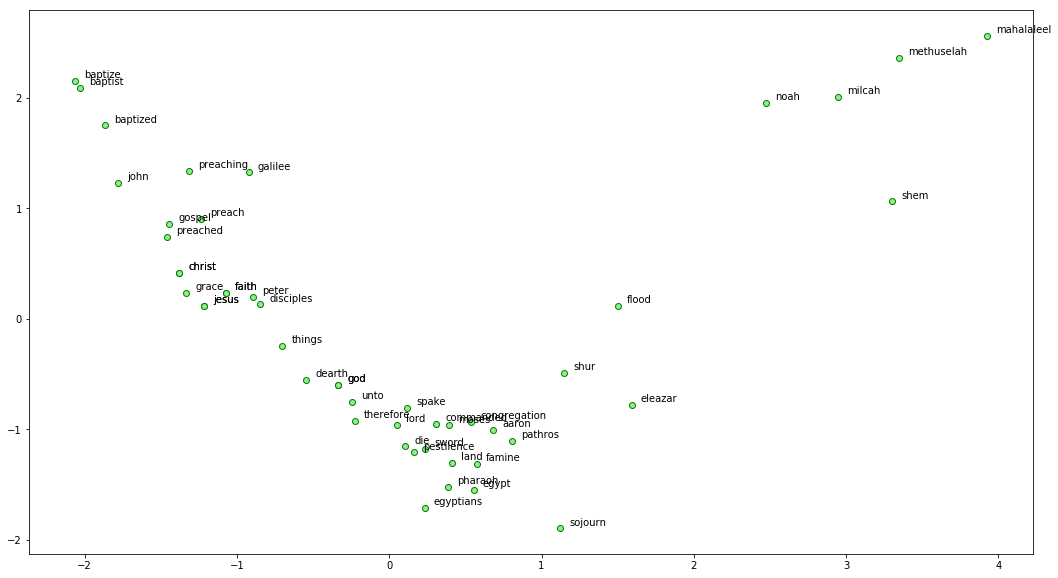

In [77]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [78]:
ft_model.wv['jesus']

array([-0.1649171 ,  0.19578025,  0.36408392,  0.25519845,  0.12820531,
       -0.19707847, -0.23944831, -0.0683662 , -0.14528628,  0.10411634,
        0.13492912,  0.05255176, -0.30615753,  0.27669582, -0.4702582 ,
        0.04004883,  0.5629165 , -0.0059088 , -0.21377191, -0.41255227,
        0.17467313,  0.05372634, -0.12034006, -0.23880008,  0.7050228 ,
       -0.01934814,  0.02232143, -0.23542348,  0.39534998,  0.18745343,
       -0.4679456 , -0.49578962, -0.00241454, -0.38651404,  0.00770097,
        0.43932804, -0.3600731 , -0.21428677, -0.31795743, -0.03721717,
        0.1408762 , -0.05317242,  0.0636579 ,  0.12769727, -0.20692684,
        0.00781541, -0.2891747 , -0.0467738 ,  0.25649223, -0.08458929,
        0.19791986, -0.24344015, -0.0531068 ,  0.162748  ,  0.01495585,
        0.07460687, -0.18401675,  0.2993984 ,  0.41913977, -0.40089524,
        0.01351643, -0.27970368,  0.3472811 , -0.2281876 ,  0.18925025,
        0.5127825 , -0.04044663, -0.02205172,  0.03082092, -0.04

In [79]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.2875352
0.6610531


In [80]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

c:\users\mglewis\appdata\local\programs\python\python36\lib\site-packages\gensim\models\keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas
